# Transformer-Based Source-Free Domain Adaptation(Transda) 논문 구현

[https://arxiv.org/abs/2105.14138](https://arxiv.org/abs/2105.14138)

## source free domain adapatation 

source data 없이 model 만을 들고와서 하는 것을 의미한다. 

이는 data privacy에 민감한 문제들을 해결할 수 있고, 저장공간을 아낄 수 있다. 

data privacy가 핵심인데, 이것이 의미하는 바는 medical 이나 face 같이 개인의 정보가 들어간 data 의 privacy를 지킬 수 있다.




## model 설명

간단하게만 설명하고 넘어가도록 하겠다.

![1.png](./images/1.PNG)

이는 resnet50 뒤에 vision transformer(Vit)를 붙인다. 이를 통해 object 의 위치(attention)을 파악할 수 있고, object의 위치를 잘 파악할 수 있게 되면, domain adapatation의 성능도 오른다는 것이 논문 저자들이 밝혀낸 바이다.

cls(classifier)는 그대로 들고온 후에 학습을 하지 않는다. teacher 모델도 학습을 하지 않는다. 대신에 epoch이 끝날 때마다, EMA 방법을 통해 student의 parameter를 복사한다. teacher 모델은 unlabeled data 에 labeling을 해주는 역할을 한다.






dataset은 Office 31 을 이용했다.

~~soruce 모델은 학습이 잘 되지만, 이상하게도 target domain에서는 작동을 잘 안 한다.~~ 2021.08.24 해결완료



In [28]:
from IPython.display import clear_output

! tar -xvf /content/drive/MyDrive/Colab\ Notebooks/office31.tar.gz
! pip install intel-openmp
! pip install timm
!nvidia-smi
clear_output()

In [29]:
import gc, os, glob
from PIL import Image

import timm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np

import matplotlib.pyplot as plt


gc.collect()
torch.cuda.empty_cache()

In [30]:
class EmptyLayer(nn.Module):
  def __init__(self):
    super(EmptyLayer, self).__init__()

  def forward(self, x):
    return x

class Transda(nn.Module):
  def __init__(self, num_classes):
    super().__init__()

    self.feature = timm.create_model('vit_base_r50_s16_224_in21k', pretrained=True)
    self.cls = nn.Linear(self.feature.head.in_features, num_classes)
    self.feature.head = EmptyLayer()

  def forward(self, x):
    feature = self.feature(x)
    cls = self.cls(feature)

    return feature, cls

  
class SmoothingCrossEntropy(nn.Module):
  def __init__(self, num_classes, smoothing=0.1, dim=-1):
    super().__init__()

    self.num_classes = num_classes
    self.smoothing = smoothing
    self.dim = dim
  
  def forward(self, pred, target):
    pred = pred.log_softmax(dim=self.dim)

    with torch.no_grad():
      true_dist = torch.zeros_like(pred)
      true_dist.fill_(self.smoothing / (self.num_classes-1))
      true_dist.scatter_(1, target.data.unsqueeze(1), 1.0-self.smoothing)
    return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))


In [31]:
def split_data(path, class_list, p=0.9):
  train_data = []
  test_data = []
  for i,class_str in enumerate(class_list):
    tmp_list = [((path+class_str+'/'+image), i) for image in os.listdir(path+class_str)]
    idx = int(len(tmp_list)*p)
    train_data += tmp_list[:idx]
    test_data += tmp_list[idx:]
  
  return train_data, test_data


DATA_PATH = ['/content/amazon/images/', '/content/dslr/images/', '/content/webcam/images/']

class_list = os.listdir(DATA_PATH[0])

amazon_train_data, amazon_test_data = split_data(DATA_PATH[0], class_list)
dslr_train_data, dslr_test_data = split_data(DATA_PATH[1], class_list)
webcam_train_data, webcam_test_data = split_data(DATA_PATH[2], class_list)



In [32]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, data, transforms):
    super().__init__()
    
    self.data = data

    self.transforms = transforms
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data, label = self.data[idx]
    #label = torch.Tensor(label)
    data = Image.open(data).convert('RGB')

    if self.transforms is not None:
      data = self.transforms(data)

    return data, label

train_transforms = transforms.Compose([
      transforms.Resize(256),
      transforms.RandomCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),                 
])

test_transforms = transforms.Compose([
      transforms.Resize(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),                 
])

In [33]:
def plot(epochs, train_losses, train_accs, test_losses, test_accs):
  clear_output()
  plt.figure(figsize = (20,5))
  plt.title('epoch {0}'.format(epochs))
  plt.subplot(221)
  plt.title('train_accuracy')
  plt.plot(train_accs)
  plt.subplot(222)
  plt.title('train_loss')
  plt.plot(train_losses)
  plt.subplot(223)
  plt.title('test_accuracy')
  plt.plot(test_accs)
  plt.subplot(224)
  plt.title('test_losses')
  plt.plot(test_losses)
  plt.tight_layout()
  plt.show()

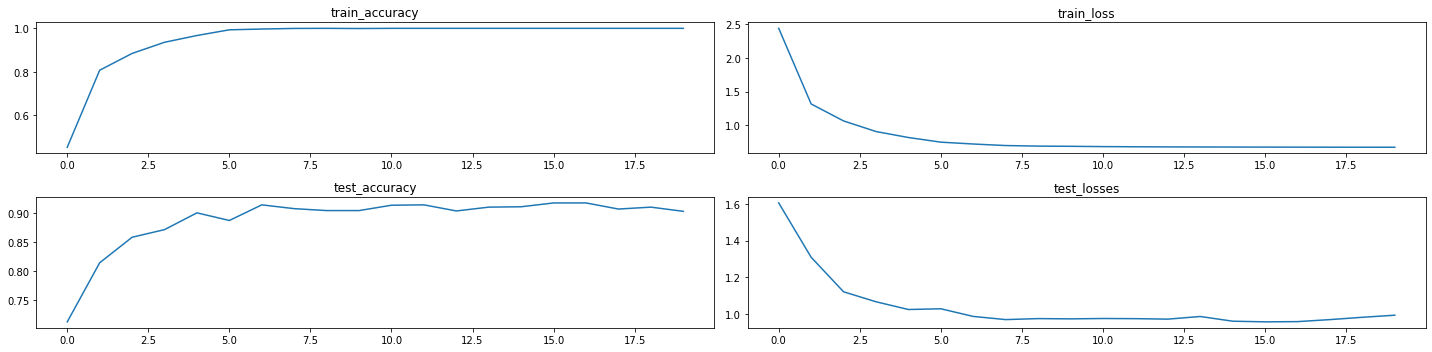

epoch 20
train_acc : 1.0
train_loss : 0.6727179288864136
test_acc : 0.9032894968986511
test_loss : 0.9944107532501221


In [35]:
def pretrain(epochs, lr, batch_size, num_classes, train_data, test_data, device, load_path=None, save_path=None):
  pretrain_model = Transda(num_classes=num_classes)
  pretrain_model.to(device)

  if load_path is not None:
    pretrain_model.load_state_dict(torch.load(load_path))

  train_dataset = MyDataset(train_data,train_transforms)
  train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True, num_workers=4)

  test_dataset = MyDataset(test_data,test_transforms)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

  optimizer = optim.SGD(pretrain_model.parameters(), lr=lr, weight_decay=0.001)
  CEloss = SmoothingCrossEntropy(num_classes=31)

  train_losses = []
  train_accs = []

  test_losses = []
  test_accs = []

  for epoch in range(1, epochs+1):
    
    train_loss = 0.
    train_acc = 0.

    test_loss = 0.
    test_acc = 0.

    pretrain_model.train()
    for data, target in train_loader:
      data = data.float().to(device)
      target = target.long().to(device)

      optimizer.zero_grad()
      _, pred = pretrain_model(data)
      loss = CEloss(pred, target)
      loss.backward()

      train_loss += loss
      train_acc += (pred.argmax(dim=1) == target).float().mean()

      optimizer.step()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    pretrain_model.eval()

    for data, target in test_loader:
      data = data.float().to(device)
      target = target.long().to(device)

      with torch.no_grad():
        _, pred = pretrain_model(data)
        loss = CEloss(pred, target)
        test_loss += loss
        test_acc += (pred.argmax(dim=1) == target).float().mean()
    
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    test_losses.append(test_loss)
    test_accs.append(test_acc)

    plot(epoch, train_losses, train_accs, test_losses, test_accs)
    print('epoch {0}'.format(epoch))
    print('train_acc : {0}'.format(train_acc))
    print('train_loss : {0}'.format(train_loss))
    print('test_acc : {0}'.format(test_acc))
    print('test_loss : {0}'.format(test_loss))

  if save_path is not None:
    torch.save(pretrain_model.state_dict(), save_path)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pretrain(20, 0.01, 16, 31, amazon_train_data, amazon_test_data, device,None, '/content/drive/MyDrive/Colab Notebooks/pretrain.pt')

In [36]:
class CrossEntropy(nn.Module):
  def init(self):
    super().__Init__()

  def forward(self, x, y):
    return ((x * -torch.log(y+1e-5)).sum(dim=1)).mean()

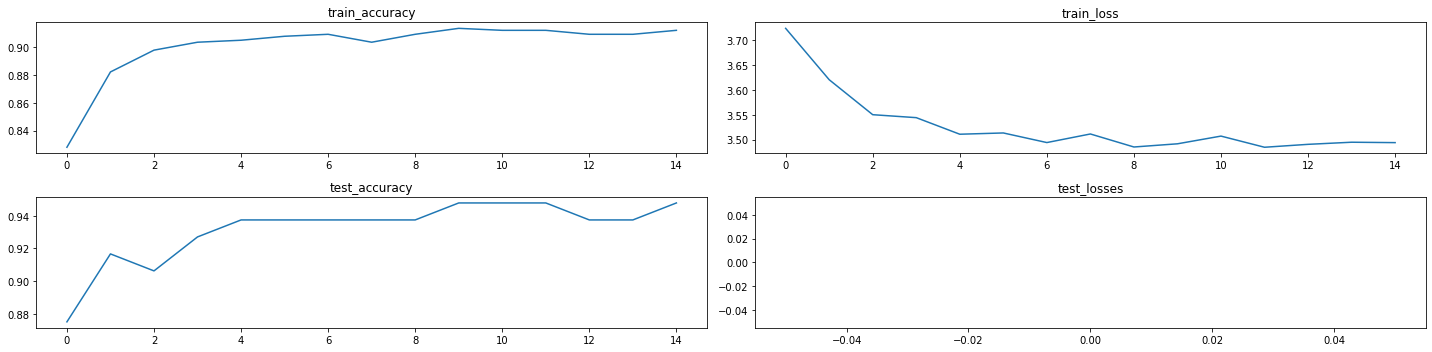

epoch 15
train_acc : 0.9119318723678589
train_loss : 3.493813991546631
test_acc : 0.9479166865348816


In [39]:
gc.collect()
torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#teacher_model
def self_labeling(model,datas, batch_size, i,device):
  start_chk = True

  with torch.no_grad():
    for idx in range(i):
      try:
        data = datas[idx*batch_size : idx*batch_size+batch_size].float().to(device)
      except:
        data = datas[idx*batch_size : ].float().to(device)

      feature, target = model(data)
      target = F.softmax(target, dim=1)


      if start_chk:
        start_chk = False
        features = feature.float()
        targets = target.float()

      else:
        features = torch.cat((features, feature.float()), dim=0)
        targets = torch.cat((targets, target.float()), dim=0)
  
  centroid = targets.transpose(0,1).matmul(features) / (1e-8 + targets.sum(axis=0)[:, None])
  similarity = torch.tensor([]).to(device)

  for i in range(features.size(0)):
    similarity = torch.cat((similarity, F.cosine_similarity(features[i].unsqueeze(0), centroid).unsqueeze(0)), dim=0)

  self_label = torch.zeros((features.size(0), targets.size(1))).to(device)
  # not distance, so argmax

  tmp_label = torch.argmax(similarity, dim= 1)
  for i in range(self_label.size(0)):
    self_label[i][tmp_label[i]] = 1


  centorid = self_label.transpose(0,1).matmul(features) / (1e-8 + self_label.sum(axis=0)[:, None])

  similarity = torch.tensor([]).to(device)
  for i in range(features.size(0)):
    similarity = torch.cat((similarity, F.cosine_similarity(features[i].unsqueeze(0), centroid).unsqueeze(0)), dim=0)

  self_label = torch.argmax(similarity, dim=1).unsqueeze(0)
  self_label = self_label.view(-1,1)


  return self_label.long().to(device), 1. - similarity



def target_train(epochs, lr, batch_size, num_classes, train_data, test_data, device, load_path, save_path):
  student_model = Transda(num_classes=num_classes)
  student_model = student_model.to(device)
  student_model.load_state_dict(torch.load(load_path, map_location=device))

  teacher_model = Transda(num_classes=num_classes)
  teacher_model = teacher_model.to(device)
  teacher_model.load_state_dict(torch.load(load_path, map_location=device))

  
  

  for i in teacher_model.parameters():
    i.required_grad = False

  for i in student_model.cls.parameters():
    i.required_grad = False


  celoss = CrossEntropy()

  optimizer = optim.SGD(student_model.parameters(),lr=lr,  momentum=0.9, weight_decay=0.001)


  train_dataset = MyDataset(train_data, transforms=train_transforms)
  test_dataset = MyDataset(test_data, transforms=test_transforms)

  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)
  test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=4)


  train_accs = []
  train_losses = []

  test_accs = []
  for epoch in range(1, epochs+1):
    
    #self_labeling
    datas = torch.tensor([]).float().to(device)
    targets = torch.tensor([]).long().to(device)
    i = 0
    for idx, (data, target) in enumerate(train_dataloader):
      data = data.float().to(device)
      target = target.long().to(device)

      datas = torch.cat((datas,data), dim=0)
      targets = torch.cat((targets, target), dim=0)
      i = idx

    teacher_model.eval()
    student_model.eval()
    self_labels, distances = self_labeling(teacher_model,  datas, batch_size,i, device)
    student_model.train()
    
    train_loss = 0.
    train_acc = 0.

    test_acc = 0.

    for idx in range(i):
      try:
        data = datas[idx*batch_size : idx*batch_size+batch_size].float().to(device)
        target = targets[idx*batch_size : idx*batch_size+batch_size].long().to(device)
      except:
        data = datas[idx*batch_size : ].float().to(device)
        target = targets[idx*batch_size: ].long().to(device)

      _ , pred = student_model(data)
      softmax_output = F.softmax(pred, dim=-1)

      im_loss = celoss(softmax_output, softmax_output)
      p=torch.mean(softmax_output, dim=0)
      p= (p*torch.log(p+1e-5)).sum()

      im_loss += p

      self_label = self_labels[idx*data.size(0): idx*data.size(0)+data.size(0)]
      self_label = torch.zeros((data.size(0), pred.size(1))).to(device)
      for i in range(data.size(0)):
        self_label[i][self_labels[idx*data.size(0)+i]] = 1
      sl_loss= celoss(self_label, softmax_output)

      distance = distances[idx*data.size(0):idx*data.size(0)+data.size(0)]
      soft_label = torch.exp(distance/0.1) / (torch.sum(torch.exp(distance/0.1), dim=1)[:, None] + 1e-8)
      kd_loss = celoss(soft_label, softmax_output)   

      tgt_loss = im_loss + 0.3*sl_loss + kd_loss

      optimizer.zero_grad()
      tgt_loss.backward()
      optimizer.step()


      train_loss += tgt_loss
      train_acc += (pred.argmax(dim=1) == target).float().mean()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    #ema
    with torch.no_grad():
      m = 0.001  # momentum parameter
      for param_q, param_k in zip(student_model.feature.parameters(), teacher_model.feature.parameters()):
        param_k.data.mul_(m).add_((1 - m) * param_q.detach().data)
    for i in teacher_model.parameters():
      i.required_grad = False
    


    for data, target in test_dataloader:
      data = data.float().to(device)
      target = target.long().to(device)
      with torch.no_grad():
        _, pred = student_model(data)
        test_acc += (pred.argmax(dim=1) == target).float().mean()
    
    test_acc /= len(test_dataloader)
    test_accs.append(test_acc)

    plot(epoch, train_losses, train_accs, [0], test_accs)
    print('epoch {0}'.format(epoch))
    print('train_acc : {0}'.format(train_acc))
    print('train_loss : {0}'.format(train_loss))
    print('test_acc : {0}'.format(test_acc))
  
  if save_path is not None:
    torch.save(student_model.state_dict(), save_path)

target_train(15, 0.001, 8, 31, webcam_train_data, webcam_test_data, device, '/content/drive/MyDrive/Colab Notebooks/pretrain.pt', '/content/drive/MyDrive/Colab Notebooks/student.pt')
